# Multi-class leaf disease classifier using PlantVillage dataset and transfer learning (EfficientNetB4)
## We have used JupyterNotebook running on GoogleColab leveraging GPU for this project

In [1]:
# ----------------------------------------
# ✅ BLOCK 1: ENVIRONMENT SETUP & DATASET
# ----------------------------------------

# ⚙️ Use mixed precision to speed up training with float16 (only if GPU supports it)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# 🧾 Import required libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
import seaborn as sns

# 🐛 Ignore any warning messages
import warnings
warnings.filterwarnings('ignore')

# 🐣 Set random seed for reproducibility (ensures consistent results)
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# 📦 Load the PlantVillage dataset (includes many types of leaf diseases)
# - Version 0.3.1 is RGB images, labeled, pre-split
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'plant_village',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],  # custom 80/10/10 split
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# 🔢 Extract class names from the dataset metadata
class_names = ds_info.features['label'].names
NUM_CLASSES = len(class_names)
print("Total Classes:", NUM_CLASSES)

# 📐 Print dataset image shape
IMG_SHAPE = ds_info.features['image'].shape
print("Image shape from TFDS:", IMG_SHAPE)  # (256, 256, 3)

# 🔍 Check image types (should be uint8 for preprocessing)
print("Image dtype:", ds_info.features['image'].dtype)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_village/incomplete.HBRPOI_1.0.2/plant_village-train.tfrecord*...:   …

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.


Total Classes: 38
Image shape from TFDS: (None, None, 3)
Image dtype: <dtype: 'uint8'>


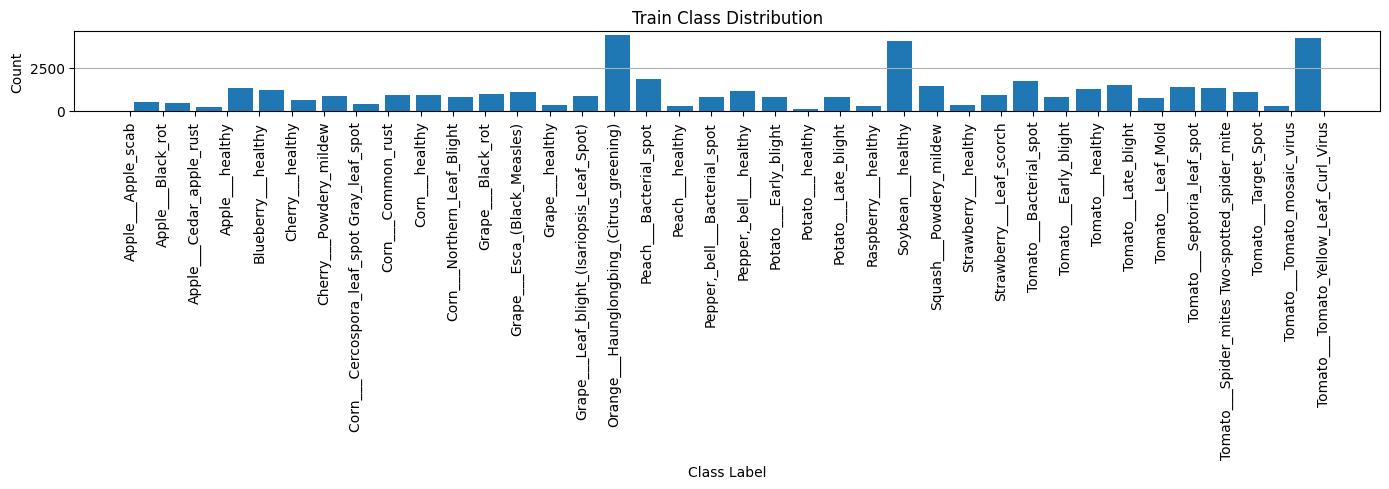

Apple___Apple_scab            : 501
Apple___Black_rot             : 467
Apple___Cedar_apple_rust      : 221
Apple___healthy               : 1306
Blueberry___healthy           : 1210
Cherry___healthy              : 659
Cherry___Powdery_mildew       : 851
Corn___Cercospora_leaf_spot Gray_leaf_spot: 405
Corn___Common_rust            : 953
Corn___healthy                : 939
Corn___Northern_Leaf_Blight   : 788
Grape___Black_rot             : 956
Grape___Esca_(Black_Measles)  : 1111
Grape___healthy               : 349
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 881
Orange___Haunglongbing_(Citrus_greening): 4399
Peach___Bacterial_spot        : 1838
Peach___healthy               : 292
Pepper,_bell___Bacterial_spot : 800
Pepper,_bell___healthy        : 1173
Potato___Early_blight         : 792
Potato___healthy              : 122
Potato___Late_blight          : 801
Raspberry___healthy           : 302
Soybean___healthy             : 4043
Squash___Powdery_mildew       : 1466
Strawberry___healthy  

In [2]:
# ----------------------------------------
# ✅ BLOCK 2: EDA - CLASS DISTRIBUTION
# ----------------------------------------

# 🔄 Convert TFDS to NumPy to analyze class distribution
y_train = []
for _, label in ds_train:
    y_train.append(label.numpy())  # Convert Tensor to int

y_val = []
for _, label in ds_val:
    y_val.append(label.numpy())

y_test = []
for _, label in ds_test:
    y_test.append(label.numpy())

# 📊 Plot training class distribution
plt.figure(figsize=(14, 5))
plt.hist(y_train, bins=NUM_CLASSES, rwidth=0.8)
plt.xticks(np.arange(NUM_CLASSES), class_names, rotation=90)
plt.title("Train Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 📊 Show class counts numerically
unique, counts = np.unique(y_train, return_counts=True)
for class_index, count in zip(unique, counts):
    print(f"{class_names[class_index]:<30}: {count}")

In [3]:
# ----------------------------------------
# ✅ BLOCK 3: DATA PREPROCESSING PIPELINE
# ----------------------------------------

# 📐 Define target image size for EfficientNetB4
IMG_SIZE = 380

# 🔁 Normalize images: uint8 → float32 in [0, 1]
def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0

    # ✅ Convert label to one-hot vector
    label = tf.one_hot(label, depth=NUM_CLASSES)

    return image, label

# 🌀 Augmentations for training images
def augment_image(image, label):
    image, label = preprocess_image(image, label)          # Always resize + normalize
    image = tf.image.random_flip_left_right(image)         # Random horizontal flip
    image = tf.image.random_brightness(image, max_delta=0.2)  # Random brightness
    image = tf.image.random_contrast(image, 0.8, 1.2)       # Random contrast
    return image, label

# 🧪 For validation & test: only resize + normalize (no augmentation!)
def no_augment(image, label):
    return preprocess_image(image, label)

# ⚙️ Build tf.data pipelines
BATCH_SIZE = 32

train_ds = ds_train.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE) \
                   .shuffle(1024) \
                   .batch(BATCH_SIZE) \
                   .prefetch(tf.data.AUTOTUNE)

val_ds = ds_val.map(no_augment, num_parallel_calls=tf.data.AUTOTUNE) \
               .batch(BATCH_SIZE) \
               .prefetch(tf.data.AUTOTUNE)

test_ds = ds_test.map(no_augment, num_parallel_calls=tf.data.AUTOTUNE) \
                 .batch(BATCH_SIZE) \
                 .prefetch(tf.data.AUTOTUNE)

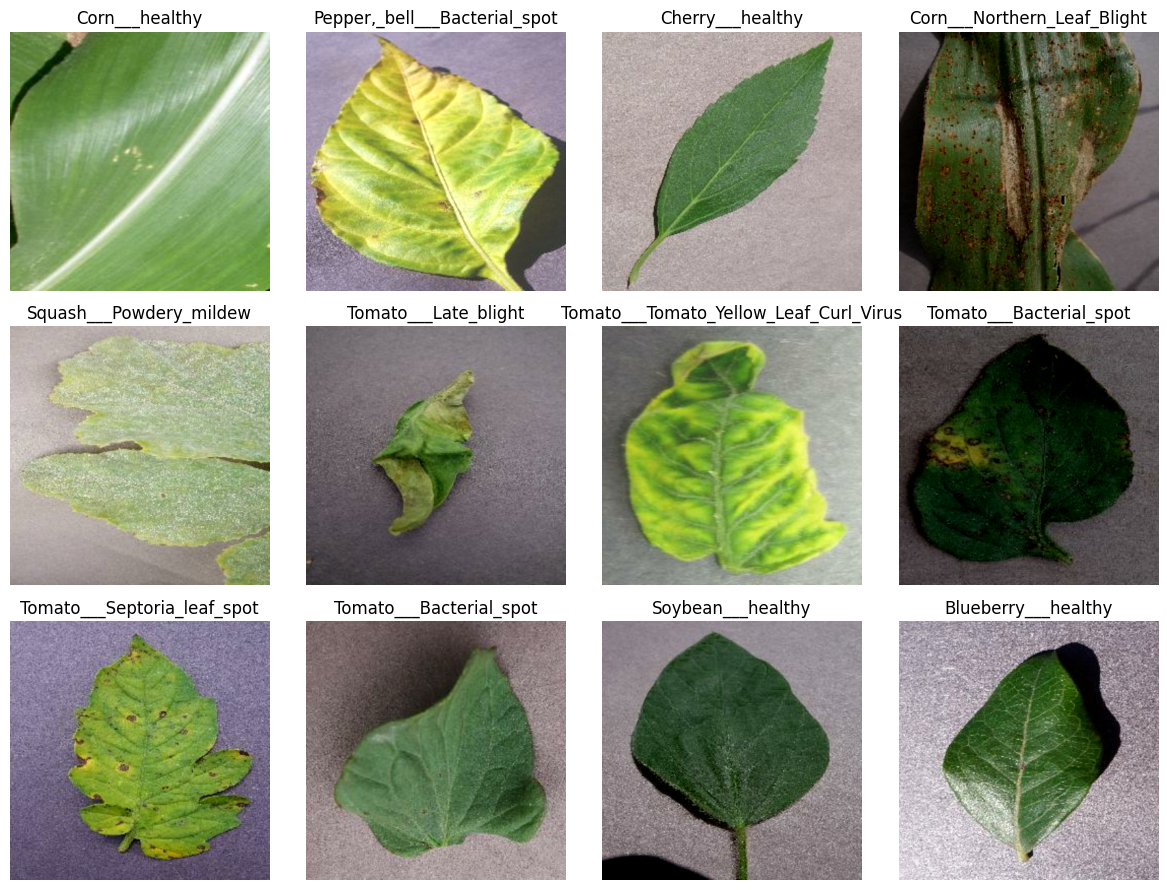

In [4]:
# ----------------------------------------
# ✅ BLOCK 4: SHOW SAMPLE IMAGES
# ----------------------------------------

# 🖼️ Function to display a grid of sample images with their class labels
def show_samples(dataset, class_names, rows=3, cols=4):
    """
    Displays a (rows x cols) grid of images and their labels.
    Input: batched tf.data.Dataset, class names
    """
    plt.figure(figsize=(cols * 3, rows * 3))  # Adjust grid size
    i = 0

    for images, labels in dataset.unbatch().take(rows * cols):
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(images.numpy())  # Convert tensor to NumPy array
        label_idx = int(np.argmax(labels.numpy()))
        plt.title(class_names[label_idx])  # Show readable class name
        plt.axis('off')
        i += 1

    plt.tight_layout()
    plt.show()

# 🔍 View 12 samples from the training set (with augmentation applied)
show_samples(train_ds, class_names, rows=3, cols=4)

Apple___Apple_scab            : weight = 2.28
Apple___Black_rot             : weight = 2.45
Apple___Cedar_apple_rust      : weight = 5.17
Apple___healthy               : weight = 0.88
Blueberry___healthy           : weight = 0.94
Cherry___healthy              : weight = 1.73
Cherry___Powdery_mildew       : weight = 1.34
Corn___Cercospora_leaf_spot Gray_leaf_spot: weight = 2.82
Corn___Common_rust            : weight = 1.20
Corn___healthy                : weight = 1.22
Corn___Northern_Leaf_Blight   : weight = 1.45
Grape___Black_rot             : weight = 1.20
Grape___Esca_(Black_Measles)  : weight = 1.03
Grape___healthy               : weight = 3.28
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): weight = 1.30
Orange___Haunglongbing_(Citrus_greening): weight = 0.26
Peach___Bacterial_spot        : weight = 0.62
Peach___healthy               : weight = 3.92
Pepper,_bell___Bacterial_spot : weight = 1.43
Pepper,_bell___healthy        : weight = 0.97
Potato___Early_blight         : weight = 1.44


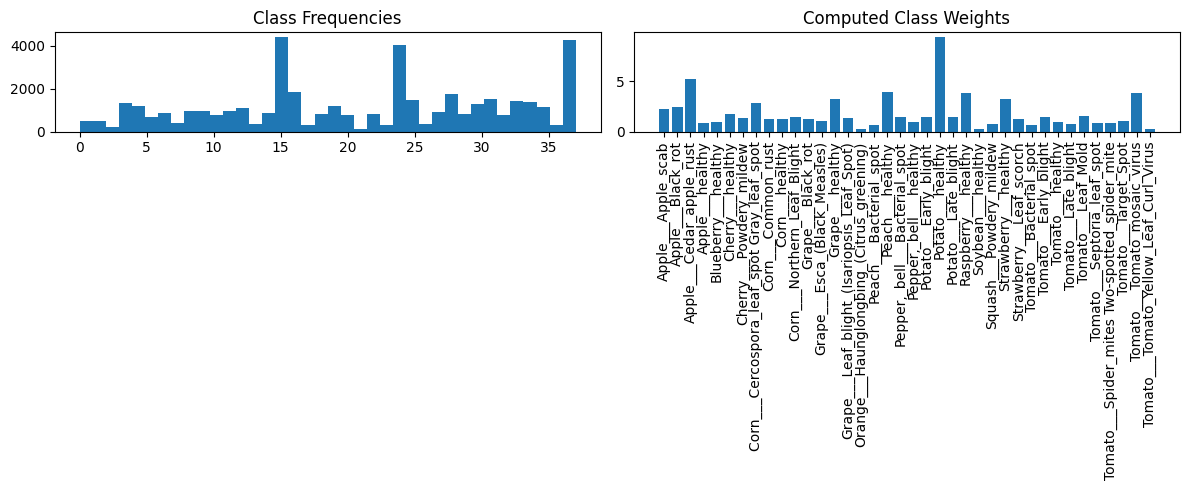

In [5]:
# ----------------------------------------
# ✅ BLOCK 5: COMPUTE CLASS WEIGHTS
# ----------------------------------------

# 🔁 Reuse the training labels (y_train) from Block 2
# We'll compute class weights based on the frequency of each class

# 📊 Compute weights inversely proportional to class frequency
# 'balanced' → ensures each class contributes equally to the loss
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# 🧪 Preview the computed weights
for i, w in enumerate(class_weights_array):
    print(f"{class_names[i]:<30}: weight = {w:.2f}")

# 🧮 Convert weights to a Tensor (for use in custom loss function later)
alpha_tensor = tf.constant(class_weights_array, dtype=tf.float32)

# 🔁 Compare class frequency and weights
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(y_train, bins=NUM_CLASSES)
plt.title("Class Frequencies")

plt.subplot(1, 2, 2)
plt.bar(np.arange(NUM_CLASSES), class_weights_array)
plt.title("Computed Class Weights")
plt.xticks(np.arange(NUM_CLASSES), class_names, rotation=90)
plt.tight_layout()
plt.show()

### As you can see some classes in PlantVillage dataset have higher weights then other. This will lead to class imbalance during model training. We will use Focal Loss with alpha balancing to manage this imbalance in training.

Focal Loss -
Focuses on hard/misclassified examples

alpha balancing -
Ensures rare classes aren’t ignored


In [6]:
# ----------------------------------------
# ✅ BLOCK 6: MODEL ARCHITECTURE (EfficientNetB4 + Focal Loss)
# ----------------------------------------

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetB4

# ⚠️ EfficientNetB4 input size = 380x380x3
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# 📦 Load pre-trained EfficientNetB4 without classification layer
base_model = EfficientNetB4(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

# 🧊 Freeze base model (for Stage 1 training only)
base_model.trainable = False

# ✅ Add classification head
inputs = layers.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)                # Prevents batch norm from updating
x = layers.GlobalAveragePooling2D()(x)                # Collapse feature maps
x = layers.Dropout(0.2)(x)                            # Dropout for regularization
x = layers.Dense(256, activation='relu')(x)           # Dense layer
x = layers.Dropout(0.3)(x)                            # More regularization
x = layers.Dense(NUM_CLASSES)(x)                      # Final logits layer (no activation yet)

# 🧪 Use float32 for final output (softmax) even with mixed precision
outputs = layers.Activation('softmax', dtype='float32')(x)

# 🏗️ Final model
model = models.Model(inputs, outputs)
model.summary()

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 12, 12, 1792)   │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       459,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         9,766 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 38)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,142,597 (69.21 MB)

 Trainable params: 468,774 (1.79 MB)

 Non-trainable params: 17,673,823 (67.42 MB)

In [7]:
# ----------------------------------------
# 🧪 FOCAL LOSS FUNCTION (α-balanced, categorical)
# ----------------------------------------

from tensorflow.keras import backend as K

def categorical_focal_loss(alpha, gamma=2.0):
    """
    alpha: tf.constant of shape [num_classes] with per-class weights
    gamma: focusing parameter
    """
    def loss_fn(y_true, y_pred):
        # ⚠️ Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

        # 🔢 Get true class index for each sample in batch
        # Assuming y_true is one-hot encoded
        class_indices = tf.argmax(y_true, axis=-1)

        # 🎯 Gather α weight for each sample’s true class
        alpha_factor = tf.gather(alpha, class_indices)  # shape: [batch_size]

        # ❌ Compute categorical cross-entropy per sample
        # Ensure sum is across the last axis
        cross_entropy = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)  # shape: [batch_size]

        # 🎯 Compute modulating factor (1 - pt)^γ
        # Ensure sum is across the last axis
        focal_weight = tf.reduce_sum(tf.pow(1 - y_pred, gamma) * y_true, axis=-1)  # shape: [batch_size]

        # 🔀 Final focal loss per sample
        loss = alpha_factor * focal_weight * cross_entropy  # shape: [batch_size]

        return tf.reduce_mean(loss)  # Return scalar loss for each batch

    return loss_fn

In [8]:
# ----------------------------------------
# ✅ COMPILE MODEL WITH MIXED PRECISION OPTIMIZER
# ----------------------------------------

# 📊 alpha must be a Tensor with shape [NUM_CLASSES]
# ⚠️ If your alpha is a NumPy array, convert it here
alpha_tensor = tf.constant(class_weights_array, dtype=tf.float32)

# 🎯 Instantiate focal loss with fixed alpha
focal_loss_fn = categorical_focal_loss(alpha=alpha_tensor, gamma=2.0)

# ⚙️ Optimizer with learning rate and mixed precision scaling
optimizer = optimizers.Adam(learning_rate=1e-4)
optimizer = mixed_precision.LossScaleOptimizer(optimizer)

# 🔧 Compile model
model.compile(
    optimizer=optimizer,
    loss=focal_loss_fn,
    metrics=['accuracy']
)

In [9]:
# ----------------------------------------
# ✅ BLOCK 7: TRAIN THE MODEL (Stage 1 - Head Only)
# ----------------------------------------

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 🛑 Stop training if val_loss doesn't improve for 5 epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# 💾 Save the best model weights to file
checkpoint = ModelCheckpoint(
    filepath='best_model_stage1.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# ▶️ Start training (EffNetB4 base frozen, only head is trained)
history_stage1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.0239 - loss: 3.4792
Epoch 1: val_loss improved from inf to 3.51386, saving model to best_model_stage1.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 347s 189ms/step - accuracy: 0.0239 - loss: 3.4791 - val_accuracy: 0.0206 - val_loss: 3.5139
Epoch 2/25
1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0268 - loss: 3.4628
Epoch 2: val_loss improved from 3.51386 to 3.51250, saving model to best_model_stage1.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 61s 44ms/step - accuracy: 0.0268 - loss: 3.4628 - val_accuracy: 0.0188 - val_loss: 3.5125
Epoch 3/25
1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0350 - loss: 3.4596
Epoch 3: val_loss improved from 3.51250 to 3.51003, saving model to best_model_stage1.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 61s 44ms/step - accuracy: 0.0350 - loss: 3.4596 - val_accuracy: 0.0191 - val_loss: 3.5100
Epoch 4/25
1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0567 - loss: 3.4663
Epoch 4: val_loss improved from 3.51003 to 3.50641, saving model to best_model_stage1.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 61s 44ms/step - accuracy: 0.0567 - loss: 3.4663 - val_accuracy: 0.0556 - val_loss: 3.5064
Epoch 5/25
1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0645 - loss: 3.4608
Epoch 5: val_loss did not improve from 3.50641
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 60s 44ms/step - accuracy: 0.0645 - loss: 3.4608 - val_accuracy: 0.0392 - val_loss: 3.5092
Epoch 6/25
1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0599 - loss: 3.4582
Epoch 6: val_loss improved from 3.50641 to 3.49529, saving model to best_model_stage1.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 61s 44ms/step - accuracy: 0.0599 - loss: 3.4582 - val_accuracy: 0.0755 - val_loss: 3.4953
Epoch 7/25
1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0728 - loss: 3.4513
Epoch 7: val_loss improved from 3.49529 to 3.48864, saving model to best_model_stage1.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 61s 44ms/step - accuracy: 0.0728 - loss: 3.4512 - val_accuracy: 0.0992 - val_loss: 3.4886
Epoch 8/25
1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0737 - loss: 3.4418
Epoch 8: val_loss improved from 3.48864 to 3.48148, saving model to best_model_stage1.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 61s 44ms/step - accuracy: 0.0737 - loss: 3.4418 - val_accuracy: 0.1090 - val_loss: 3.4815
Epoch 9/25
1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0817 - loss: 3.4458
Epoch 9: val_loss improved from 3.48148 to 3.47373, saving model to best_model_stage1.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 61s 44ms/step - accuracy: 0.0817 - loss: 3.4458 - val_accuracy: 0.1055 - val_loss: 3.4737
Epoch 10/25
1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0857 - loss: 3.4353
Epoch 10: val_loss improved from 3.47373 to 3.46578, saving model to best_model_stage1.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 61s 44ms/step - accuracy: 0.0857 - loss: 3.4353 - val_accuracy: 0.1131 - val_loss: 3.4658
Epoch 11/25
1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0869 - loss: 3.4300
Epoch 11: val_loss improved from 3.46578 to 3.45918, saving model to best_model_stage1.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 61s 44ms/step - accuracy: 0.0869 - loss: 3.4299 - val_accuracy: 0.1138 - val_loss: 3.4592
Epoch 12/25
1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0877 - loss: 3.4312
Epoch 12: val_loss improved from 3.45918 to 3.45137, saving model to best_model_stage1.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 60s 44ms/step - accuracy: 0.0877 - loss: 3.4312 - val_accuracy: 0.1092 - val_loss: 3.4514
Epoch 13/25
1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0823 - loss: 3.4340
Epoch 13: val_loss improved from 3.45137 to 3.44975, saving model to best_model_stage1.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 61s 44ms/step - accuracy: 0.0823 - loss: 3.4340 - val_accuracy: 0.1180 - val_loss: 3.4498
Epoch 14/25
1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0854 - loss: 3.4281
Epoch 14: val_loss improved from 3.44975 to 3.43907, saving model to best_model_stage1.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 60s 44ms/step - accuracy: 0.0854 - loss: 3.4281 - val_accuracy: 0.1059 - val_loss: 3.4391
Epoch 15/25
1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0807 - loss: 3.4273
Epoch 15: val_loss improved from 3.43907 to 3.43552, saving model to best_model_stage1.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 61s 44ms/step - accuracy: 0.0807 - loss: 3.4273 - val_accuracy: 0.1156 - val_loss: 3.4355
Epoch 16/25
1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0791 - loss: 3.4204
Epoch 16: val_loss improved from 3.43552 to 3.42919, saving model to best_model_stage1.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 61s 45ms/step - accuracy: 0.0791 - loss: 3.4204 - val_accuracy: 0.1158 - val_loss: 3.4292
Epoch 17/25
1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0790 - loss: 3.4213
Epoch 17: val_loss improved from 3.42919 to 3.42650, saving model to best_model_stage1.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 61s 44ms/step - accuracy: 0.0790 - loss: 3.4213 - val_accuracy: 0.1121 - val_loss: 3.4265
Epoch 18/25
1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0826 - loss: 3.4151
Epoch 18: val_loss improved from 3.42650 to 3.41574, saving model to best_model_stage1.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 61s 44ms/step - accuracy: 0.0826 - loss: 3.4151 - val_accuracy: 0.1085 - val_loss: 3.4157
Epoch 19/25
1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0808 - loss: 3.4144
Epoch 19: val_loss improved from 3.41574 to 3.41226, saving model to best_model_stage1.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 60s 44ms/step - accuracy: 0.0808 - loss: 3.4144 - val_accuracy: 0.1103 - val_loss: 3.4123
Epoch 20/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0838 - loss: 3.4153
Epoch 20: val_loss did not improve from 3.41226
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 60s 44ms/step - accuracy: 0.0838 - loss: 3.4153 - val_accuracy: 0.1101 - val_loss: 3.4124
Epoch 21/25
1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0876 - loss: 3.4105
Epoch 21: val_loss improved from 3.41226 to 3.40343, saving model to best_model_stage1.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 60s 44ms/step - accuracy: 0.0876 - loss: 3.4104 - val_accuracy: 0.1108 - val_loss: 3.4034
Epoch 22/25
1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0846 - loss: 3.4061
Epoch 22: val_loss did not improve from 3.40343
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 60s 44ms/step - accuracy: 0.0846 - loss: 3.4061 - val_accuracy: 0.1110 - val_loss: 3.4058
Epoch 23/25
1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0865 - loss: 3.4124
Epoch 23: val_loss improved from 3.40343 to 3.39709, saving model to best_model_stage1.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 60s 44ms/step - accuracy: 0.0865 - loss: 3.4123 - val_accuracy: 0.1110 - val_loss: 3.3971
Epoch 24/25
1357/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0849 - loss: 3.4098
Epoch 24: val_loss improved from 3.39709 to 3.39663, saving model to best_model_stage1.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 60s 44ms/step - accuracy: 0.0849 - loss: 3.4098 - val_accuracy: 0.1164 - val_loss: 3.3966
Epoch 25/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0870 - loss: 3.4052
Epoch 25: val_loss improved from 3.39663 to 3.39020, saving model to best_model_stage1.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 61s 44ms/step - accuracy: 0.0870 - loss: 3.4052 - val_accuracy: 0.1094 - val_loss: 3.3902


In [10]:
# ----------------------------------------
# ✅ BLOCK 8: FINE-TUNE FULL MODEL (Stage 2)
# ----------------------------------------

# 🔓 Unfreeze the base model so we can fine-tune all layers
base_model.trainable = True

# ⚠️ It's important to compile again after changing model trainability
model.compile(
    optimizer=mixed_precision.LossScaleOptimizer(
        optimizers.Adam(learning_rate=1e-5)  # 🔽 Lower LR to avoid destroying pre-trained weights
    ),
    loss=focal_loss_fn,
    metrics=['accuracy']
)

# 📋 Show how many layers are now trainable
print(f"Total layers: {len(model.layers)}")
print(f"Trainable layers: {len([layer for layer in model.layers if layer.trainable])}")

# 🛑 Setup callbacks again (can reuse same ones)
checkpoint_stage2 = ModelCheckpoint(
    filepath='best_model_stage2.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stop_stage2 = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# ▶️ Train the full model (head + base)
history_stage2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[early_stop_stage2, checkpoint_stage2]
)

Total layers: 8
Trainable layers: 8
Epoch 1/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.1774 - loss: 2.9044
Epoch 1: val_loss improved from inf to 1.06164, saving model to best_model_stage2.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 796s 358ms/step - accuracy: 0.1776 - loss: 2.9039 - val_accuracy: 0.7291 - val_loss: 1.0616
Epoch 2/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7465 - loss: 0.7231
Epoch 2: val_loss improved from 1.06164 to 0.22876, saving model to best_model_stage2.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 146s 107ms/step - accuracy: 0.7466 - loss: 0.7230 - val_accuracy: 0.9024 - val_loss: 0.2288
Epoch 3/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8764 - loss: 0.2661
Epoch 3: val_loss improved from 0.22876 to 0.08132, saving model to best_model_stage2.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 148s 108ms/step - accuracy: 0.8764 - loss: 0.2661 - val_accuracy: 0.9527 - val_loss: 0.0813
Epoch 4/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9223 - loss: 0.1457
Epoch 4: val_loss improved from 0.08132 to 0.04500, saving model to best_model_stage2.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 147s 108ms/step - accuracy: 0.9223 - loss: 0.1457 - val_accuracy: 0.9704 - val_loss: 0.0450
Epoch 5/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9426 - loss: 0.0968
Epoch 5: val_loss did not improve from 0.04500
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 145s 107ms/step - accuracy: 0.9426 - loss: 0.0968 - val_accuracy: 0.9698 - val_loss: 0.0461
Epoch 6/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9562 - loss: 0.0711
Epoch 6: val_loss improved from 0.04500 to 0.04143, saving model to best_model_stage2.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 147s 108ms/step - accuracy: 0.9562 - loss: 0.0711 - val_accuracy: 0.9735 - val_loss: 0.0414
Epoch 7/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9619 - loss: 0.0559
Epoch 7: val_loss improved from 0.04143 to 0.02074, saving model to best_model_stage2.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 147s 108ms/step - accuracy: 0.9619 - loss: 0.0559 - val_accuracy: 0.9842 - val_loss: 0.0207
Epoch 8/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9700 - loss: 0.0434
Epoch 8: val_loss did not improve from 0.02074
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 145s 106ms/step - accuracy: 0.9700 - loss: 0.0434 - val_accuracy: 0.9862 - val_loss: 0.0217
Epoch 9/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9756 - loss: 0.0357
Epoch 9: val_loss improved from 0.02074 to 0.01814, saving model to best_model_stage2.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 146s 107ms/step - accuracy: 0.9756 - loss: 0.0357 - val_accuracy: 0.9886 - val_loss: 0.0181
Epoch 10/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9803 - loss: 0.0276
Epoch 10: val_loss improved from 0.01814 to 0.01797, saving model to best_model_stage2.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 146s 107ms/step - accuracy: 0.9803 - loss: 0.0276 - val_accuracy: 0.9899 - val_loss: 0.0180
Epoch 11/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9822 - loss: 0.0233
Epoch 11: val_loss improved from 0.01797 to 0.01693, saving model to best_model_stage2.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 146s 107ms/step - accuracy: 0.9822 - loss: 0.0233 - val_accuracy: 0.9899 - val_loss: 0.0169
Epoch 12/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9859 - loss: 0.0184
Epoch 12: val_loss improved from 0.01693 to 0.01104, saving model to best_model_stage2.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 147s 108ms/step - accuracy: 0.9859 - loss: 0.0184 - val_accuracy: 0.9913 - val_loss: 0.0110
Epoch 13/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9875 - loss: 0.0162
Epoch 13: val_loss improved from 0.01104 to 0.01102, saving model to best_model_stage2.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 146s 108ms/step - accuracy: 0.9875 - loss: 0.0162 - val_accuracy: 0.9932 - val_loss: 0.0110
Epoch 14/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9877 - loss: 0.0150
Epoch 14: val_loss did not improve from 0.01102
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 145s 106ms/step - accuracy: 0.9877 - loss: 0.0150 - val_accuracy: 0.9915 - val_loss: 0.0121
Epoch 15/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9901 - loss: 0.0123
Epoch 15: val_loss did not improve from 0.01102
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 144s 105ms/step - accuracy: 0.9901 - loss: 0.0123 - val_accuracy: 0.9716 - val_loss: 0.0498
Epoch 16/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9902 - loss: 0.0126
Epoch 16: val_loss improved from 0.01102 to 0.01094, saving model to best_model_stage2.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 147s 108ms/step - accuracy: 0.9902 - loss: 0.0126 - val_accuracy: 0.9943 - val_loss: 0.0109
Epoch 17/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9913 - loss: 0.0102
Epoch 17: val_loss improved from 0.01094 to 0.01068, saving model to best_model_stage2.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 147s 108ms/step - accuracy: 0.9913 - loss: 0.0102 - val_accuracy: 0.9917 - val_loss: 0.0107
Epoch 18/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9922 - loss: 0.0093
Epoch 18: val_loss did not improve from 0.01068
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 145s 107ms/step - accuracy: 0.9922 - loss: 0.0093 - val_accuracy: 0.9886 - val_loss: 0.0200
Epoch 19/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9929 - loss: 0.0088
Epoch 19: val_loss improved from 0.01068 to 0.00828, saving model to best_model_stage2.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 146s 107ms/step - accuracy: 0.9929 - loss: 0.0088 - val_accuracy: 0.9947 - val_loss: 0.0083
Epoch 20/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9935 - loss: 0.0080
Epoch 20: val_loss did not improve from 0.00828
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 145s 106ms/step - accuracy: 0.9935 - loss: 0.0080 - val_accuracy: 0.9939 - val_loss: 0.0089
Epoch 21/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9939 - loss: 0.0068
Epoch 21: val_loss improved from 0.00828 to 0.00684, saving model to best_model_stage2.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 146s 107ms/step - accuracy: 0.9939 - loss: 0.0068 - val_accuracy: 0.9948 - val_loss: 0.0068
Epoch 22/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9952 - loss: 0.0068
Epoch 22: val_loss did not improve from 0.00684
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 144s 106ms/step - accuracy: 0.9952 - loss: 0.0068 - val_accuracy: 0.9948 - val_loss: 0.0120
Epoch 23/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9945 - loss: 0.0058
Epoch 23: val_loss improved from 0.00684 to 0.00494, saving model to best_model_stage2.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 147s 108ms/step - accuracy: 0.9945 - loss: 0.0058 - val_accuracy: 0.9959 - val_loss: 0.0049
Epoch 24/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9955 - loss: 0.0052
Epoch 24: val_loss did not improve from 0.00494
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 145s 106ms/step - accuracy: 0.9955 - loss: 0.0052 - val_accuracy: 0.9947 - val_loss: 0.0103
Epoch 25/25
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9955 - loss: 0.0046
Epoch 25: val_loss did not improve from 0.00494
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 144s 106ms/step - accuracy: 0.9955 - loss: 0.0046 - val_accuracy: 0.9917 - val_loss: 0.0174


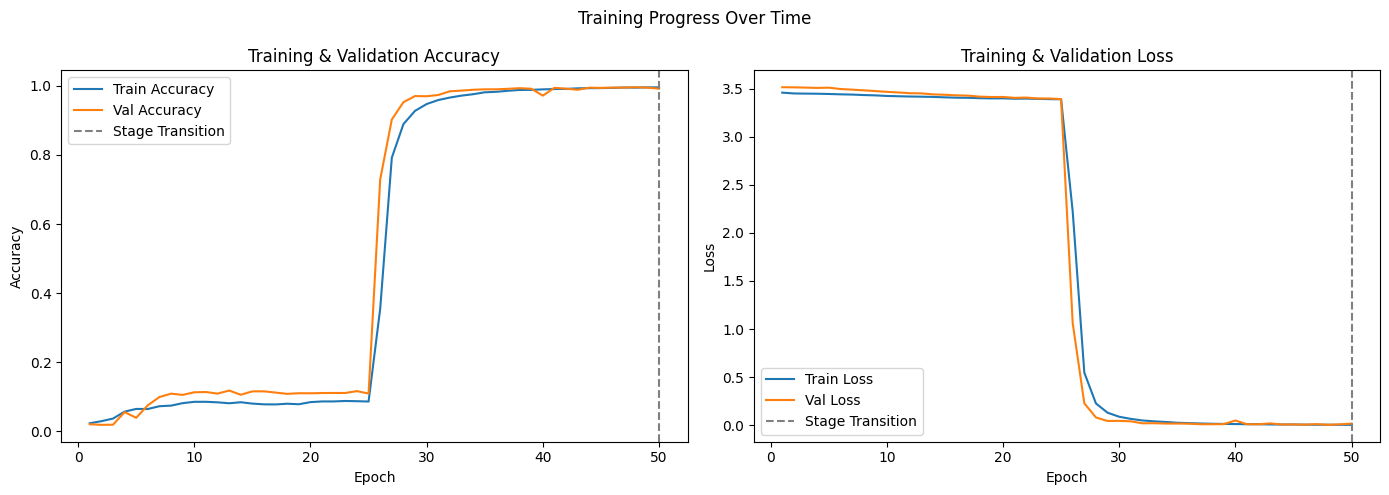

In [11]:
# ----------------------------------------
# ✅ BLOCK 9: PLOT TRAINING & VALIDATION CURVES
# ----------------------------------------

import matplotlib.pyplot as plt

def plot_training_curves(history1, history2=None, stage1_label='Stage 1', stage2_label='Stage 2'):
    """
    Plots training and validation accuracy/loss for one or two training stages.
    Accepts:
        - history1: Keras history object (Stage 1)
        - history2: Optional second history object (Stage 2)
    """

    # 📈 Merge histories (if stage 2 provided)
    acc = history1.history['accuracy']
    val_acc = history1.history['val_accuracy']
    loss = history1.history['loss']
    val_loss = history1.history['val_loss']

    if history2:
        acc += history2.history['accuracy']
        val_acc += history2.history['val_accuracy']
        loss += history2.history['loss']
        val_loss += history2.history['val_loss']

    # 📍 Create epoch range
    total_epochs = range(1, len(acc) + 1)

    # 🎨 Plot Accuracy
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(total_epochs, acc, label='Train Accuracy')
    plt.plot(total_epochs, val_acc, label='Val Accuracy')
    if history2:
        plt.axvline(x=len(history1.history['accuracy']), color='gray', linestyle='--', label='Stage Transition')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 🎨 Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(total_epochs, loss, label='Train Loss')
    plt.plot(total_epochs, val_loss, label='Val Loss')
    if history2:
        plt.axvline(x=len(history1.history['loss']), color='gray', linestyle='--', label='Stage Transition')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.suptitle('Training Progress Over Time')
    plt.tight_layout()
    plt.show()

# ▶️ Call the function to plot both stages
plot_training_curves(history_stage1, history_stage2)